In [149]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares
import pandas as pd
import os
from mpl_toolkits import mplot3d
from scipy.linalg import lstsq
import math

# Kv Value Fitting by Vial Case

## Initial Visualization

In [6]:
#Load Data
file_location = r'C:\Users\sbadih\OneDrive - Gilead Sciences\Kv Parameters for Different Vial Cases.xlsx'
assert os.path.isfile(file_location)
df = pd.read_excel(file_location,sheet_name='KV Data')
#df = pd.read_excel(file_location)
print(list(df.columns))

['Pressure (mTorr)', 'Temp ( C)', 'Vial 1', 'Vial 2', 'Vial 3', 'Vial 4', 'Vial 5', 'Vial 9', 'Vial 11', 'Vial 12', 'Vial 13', 'Vial 14', 'Averages']


In [7]:
print(df)

   Pressure (mTorr)  Temp ( C)    Vial 1    Vial 2    Vial 3    Vial 4  \
0               100 -33.559392  0.001987  0.001628  0.002037  0.001801   
1                50 -33.559392  0.001440  0.001136  0.001566  0.001305   
2                30 -33.559392  0.001099  0.000854  0.001215  0.000997   
3               300 -16.974400  0.001167  0.000968  0.001158  0.001058   
4               200 -16.974400  0.000870  0.000710  0.000860  0.000789   
5               100 -16.974400  0.000617  0.000500  0.000629  0.000559   
6                50 -16.974400  0.000499  0.000399  0.000515  0.000453   
7                30 -16.974400  0.000447  0.000357  0.000468  0.000405   

     Vial 5    Vial 9   Vial 11   Vial 12   Vial 13   Vial 14  Averages  
0  0.001770  0.001433  0.001594  0.001164  0.001622  0.001352  0.001639  
1  0.001361  0.001038  0.001156  0.000812  0.001247  0.001039  0.001210  
2  0.001056  0.000793  0.000882  0.000610  0.000968  0.000806  0.000928  
3  0.001006  0.000841  0.000936  0.00

Text(0.5, 0, 'Kv')

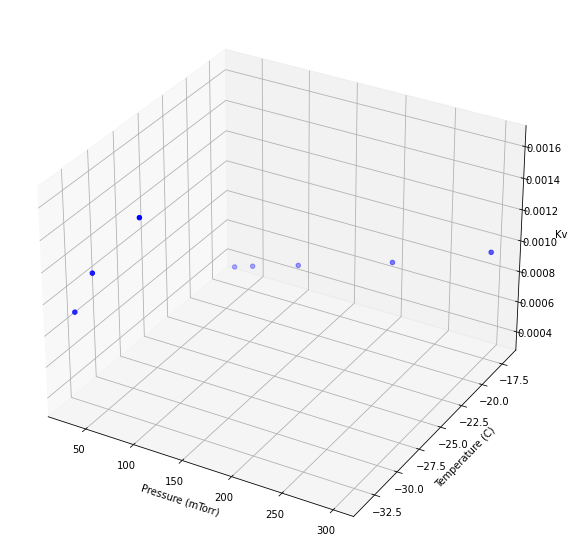

In [22]:
#Plot Kv Values
plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
pressure=(df[['Pressure (mTorr)']]).values
Kv=(df[['Averages']]).values
temperature=(df[['Temp ( C)']]).values
# Data for three-dimensional scattered points
zdata = Kv
xdata = pressure
ydata = temperature
ax.scatter3D(xdata, ydata, zdata, color="b")
ax.set_xlabel('Pressure (mTorr)')
ax.set_ylabel('Temperature (C)')
ax.set_zlabel('Kv')

## Hyperplane Fitting

In [35]:
#Matrix Setup for Least Squares
ones=(np.ones(len(pressure))).reshape(8,1)
A=np.hstack((pressure,temperature,ones))
print("A Matrix:\n",A)
print("Kv Matrix:\n",Kv)

A Matrix:
 [[100.         -33.55939227   1.        ]
 [ 50.         -33.55939227   1.        ]
 [ 30.         -33.55939227   1.        ]
 [300.         -16.9744       1.        ]
 [200.         -16.9744       1.        ]
 [100.         -16.9744       1.        ]
 [ 50.         -16.9744       1.        ]
 [ 30.         -16.9744       1.        ]]
Kv Matrix:
 [[0.00163862]
 [0.00121015]
 [0.0009279 ]
 [0.00095182]
 [0.00070636]
 [0.00050685]
 [0.00041127]
 [0.00037042]]


In [38]:
#Fitting using pseudoinverse
fit, residual, rnk, s = lstsq(A, Kv)
print("Fitted Parameters:\n",fit)

Fitted Parameters:
 [[ 2.50434209e-06]
 [-5.18465628e-05]
 [-6.31311756e-04]]


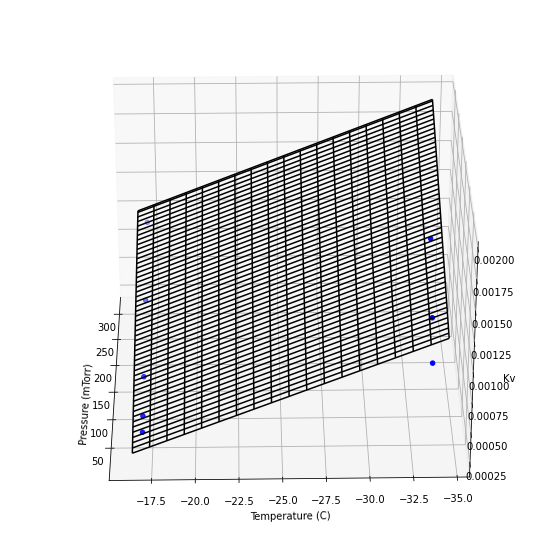

In [61]:
#Plot
plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
pressure=(df[['Pressure (mTorr)']]).values
Kv=(df[['Averages']]).values
temperature=(df[['Temp ( C)']]).values
# Data for three-dimensional scattered points
zdata = Kv
xdata = pressure
ydata = temperature
ax.scatter3D(xdata, ydata, zdata, color="b")
ax.set_xlabel('Pressure (mTorr)')
ax.set_ylabel('Temperature (C)')
ax.set_zlabel('Kv')

# plot fitted hyperplane
xlim = ax.get_xlim()
ylim = ax.get_ylim()
X,Y = np.meshgrid(np.arange(xlim[0], xlim[1]),
                  np.arange(ylim[0], ylim[1]))
Z = np.zeros(X.shape)
for r in range(X.shape[0]):
    for c in range(X.shape[1]):
        Z[r,c] = fit[0] * X[r,c] + fit[1] * Y[r,c] + fit[2]
ax.plot_wireframe(X,Y,Z, color='k')
# rotate the axes and update
for angle in range(0, 180):
   ax.view_init(30, angle)

## Predictions for our Operating Conditions

In [59]:
print("Hyperplane Parameters:\n",fit)

Hyperplane Parameters:
 [[ 2.50434209e-06]
 [-5.18465628e-05]
 [-6.31311756e-04]]


In [47]:
def kv_pred(P,T):
    kv=fit[0]*P+fit[1]*(T)+fit[2]
    return kv

In [50]:
## Low Low Cycles (-10C,75mTorr)
kv_low=kv_pred(75,-10)
print("Kv Low:",kv_low)

Kv Low: [7.49795279e-05]


In [51]:
## High High Cycles (0 C,125 mTorr)
kv_high=kv_pred(125,0)
print("Kv High:",kv_high)

Kv High: [-0.00031827]


In [57]:
## Interpolated Kv for F4 run
kv_int=kv_pred(75,-17.5)
print("Kv for F4 LL:",kv_int)

Kv for F4 LL: [0.00046383]


## Backtracking Kv from TDLAS Data (F4 LL Cycle)

In [107]:
#Load Data
#Initial Data
file_location1 = r'C:\Users\sbadih\OneDrive - Gilead Sciences\Trodelvy 2.0 Modelling Data\TDLAS Data-F4LL.xlsx'
assert os.path.isfile(file_location1)
df1 = pd.read_excel(file_location1,sheet_name='Sheet2')
print(list(df1.columns))

#Initial Data(SV File)
file_location2 = r'C:\Users\sbadih\OneDrive - Gilead Sciences\Trodelvy 2.0 Modelling Data\220701_GS0132_F4_SV_mins.xlsx'
assert os.path.isfile(file_location2)
df2 = pd.read_excel(file_location2,sheet_name='in')
print(list(df2.columns))

# Load Data(PP File)
file_location3 = r'C:\Users\sbadih\OneDrive - Gilead Sciences\Trodelvy 2.0 Modelling Data\220701_GS0132_F4_PP_mins.xlsx'
assert os.path.isfile(file_location3)
df3 = pd.read_excel(file_location3,sheet_name='in')
print("Headers:")
print(list(df3.columns))

['Date/Time', 'Delta Time from filestart', 'Process [H2O]', 'Refcell [H2O]', 'Velocity', 'Mass Flow (g/s)', 'Mass Flow Scaling', 'Process Purge', 'RefCell Purge', 'Pressure', 'Process Temp', 'RefCell Temp', 'Shelf Temp', 'Error Code', 'Unnamed: 14', 'per data point', 'per data point.1', 'Removal']
['Timestamp', ' SPLYO.CONDENSER_TEMPERATURE.F_CV', ' SPLYO.SHELF_OUTLET.F_CV', ' SPLYO.SHELF_INLET.F_CV', ' SPLYO.SHELF_SP.F_CV', ' SPLYO.TC_AVG.F_CV', ' SPLYO.VACUUM_SP.F_CV', ' SPLYO.CHAMBER_CM.F_CV', ' SPLYO.ROUGH_VACUUM.F_CV', ' SPLYO.CHAMBER_PIRANI.F_CV', ' SPLYO.CONDENSER_VACUUM.F_CV', 'Time', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16']
Headers:
['Timestamp', ' SPLYO.TC01.F_CV', ' SPLYO.TC02.F_CV', ' SPLYO.TC03.F_CV', ' SPLYO.TC04.F_CV', ' SPLYO.TC05.F_CV', ' SPLYO.TC06.F_CV', ' SPLYO.TC07.F_CV', ' SPLYO.TC08.F_CV', ' SPLYO.TC09.F_CV', ' SPLYO.TC10.F_CV', ' SPLYO.TC11.F_CV', ' SPLYO.TC12.F_CV', ' SPLYO.TC13.F_CV', ' SPLYO.TC14.F_CV', ' SPLYO.TC15.F_CV', ' 

##### Note: TDLAS data is every minute but the lyo data is every 5 mins, so have to adjust the sampling from TDLAS to back calculate the Kv.

In [108]:
#Define needed parameters/inputs
SAout=7.0685775
vial_number=86 #number of filled vials used
T_shelf= ((df2[[' SPLYO.SHELF_SP.F_CV']]).values).reshape(-1)
T_p_2NN=((df3[[' SPLYO.TC06.F_CV']]).values).reshape(-1)
T_p_3NN=((df3[[' SPLYO.TC03.F_CV']]).values).reshape(-1)
T_p_4NN=((df3[[' SPLYO.TC01.F_CV']]).values).reshape(-1)

print(T_shelf.shape)
print(T_p_2NN.shape)

(1440,)
(1440,)


In [151]:
#Extract sublimation rate (g/s)

#Need to extract data every five minutes only
mf=(df1[['Mass Flow (g/s)']]).values
mf=mf.reshape(-1)

#Elapsed Time Array
time=(df2[['Timestamp']]).values #every 5 mins
ind=(np.arange(0,len(time)*5,5)) #Create array for time passed in increments of 5 mins

#Find index of ind array where the mf.shape value exists
w=np.where(ind==mf.shape[0])
w=np.asarray(w)

#Truncate the ind array only up to that index
ind=ind[0:w[0,0]]
#Extract elements of mf using the ind array
mf_new=mf[ind]

#Convert mass flow to (g/s/vial)
sub_rate=mf_new/vial_number

#Calculate Heat Flow
hf=sub_rate*676/SAout

#Truncate Tshelf and Tp based on mf shape
T_shelf_new=T_shelf[0:mf_new.shape[0]]
T_p_2NN_new=T_p_2NN[0:mf_new.shape[0]]
T_p_3NN_new=T_p_3NN[0:mf_new.shape[0]]
T_p_4NN_new=T_p_4NN[0:mf_new.shape[0]]

#Find Kv based on Heat Flow
kv_2_old=hf/(T_shelf_new-T_p_2NN_new)
kv_3_old=hf/(T_shelf_new-T_p_3NN_new)
kv_4_old=hf/(T_shelf_new-T_p_4NN_new)
print(kv_2_old.shape)
print(kv_3_old.shape)
print(kv_4_old.shape)
#Remove any infinite values due to divide by zero
for i in range(kv_2_old.shape[0]):
    if kv_2_old[i]==float('+inf'):
        kv_2=np.delete(kv_2_old, i)
    if kv_3_old[i]==float('+inf'):
        kv_3=np.delete(kv_3_old,i)
    if kv_4_old[i]==float('+inf'):
        kv_4=np.delete(kv_4_old,i)
print(kv_2.shape)
print(kv_3.shape)
print(kv_4.shape)

(1328,)
(1328,)
(1328,)
(1327,)
(1327,)
(1327,)


<ipython-input-151-44a7cfc96c1e>:33: RuntimeWarning: divide by zero encountered in true_divide
  kv_2_old=hf/(T_shelf_new-T_p_2NN_new)
<ipython-input-151-44a7cfc96c1e>:34: RuntimeWarning: divide by zero encountered in true_divide
  kv_3_old=hf/(T_shelf_new-T_p_3NN_new)
<ipython-input-151-44a7cfc96c1e>:35: RuntimeWarning: divide by zero encountered in true_divide
  kv_4_old=hf/(T_shelf_new-T_p_4NN_new)


[ 0.00000000e+00  7.80505548e-06  6.21822942e-06 ... -9.53787510e-07
 -9.61182504e-07 -9.67799078e-07]
[ 0.00000000e+00  7.53591563e-06  6.00380771e-06 ... -1.90757502e-06
 -1.92236501e-06 -1.93559816e-06]
[ 0.00000000e+00  9.29964057e-06  7.40895420e-06 ... -6.35858340e-07
 -6.40788336e-07 -6.45199386e-07]


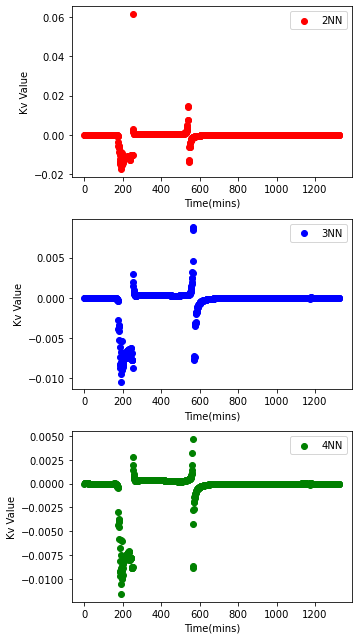

In [207]:
#Output
print(kv_2)
print(kv_3)
print(kv_4)

#Plot
plt.figure(figsize=(5, 9))
plt.subplot(3,1,1)
plt.scatter(np.arange(0,kv_2.shape[0],1),kv_2,color="red",label="2NN")
plt.xlabel("Time(mins)")
plt.ylabel("Kv Value")
plt.legend()
plt.subplot(3,1,2)
plt.scatter(np.arange(0,kv_3.shape[0],1),kv_3,color="blue",label="3NN")
plt.xlabel("Time(mins)")
plt.ylabel("Kv Value")
plt.legend()
plt.subplot(3,1,3)
plt.scatter(np.arange(0,kv_4.shape[0],1),kv_4,color="green",label="4NN")
plt.xlabel("Time(mins)")
plt.ylabel("Kv Value")
plt.legend()
plt.tight_layout()

In [147]:
def sse(x1,x2):
    sse=[]
    for i in range(len(x1)):
        sse.append(math.pow(x1[i]-x2[i],2))
    sse=np.array(sse)
    return np.sum(sse)

In [150]:
print("SSE for Kv2 vs Kv3:",sse(kv_2,kv_3))
print("SSE for Kv3 vs Kv4:",sse(kv_3,kv_4))
print("SSE for Kv2 vs Kv4:",sse(kv_2,kv_4))

SSE for Kv2 vs Kv3: nan
SSE for Kv3 vs Kv4: nan
SSE for Kv2 vs Kv4: nan


<ipython-input-147-3c288966048c>:4: RuntimeWarning: invalid value encountered in double_scalars
  sse.append(math.pow(x1[i]-x2[i],2))


### Note: Warning indicates that the difference is too small for python to store so it outputs a nan. This means no significant different is found between Kv values based on vial nearest neighbour configuration.

Number of Outliers for 2NN : 523
(804,)
Number of Negative Values for 2NN : 690
(114,)
Number of Outliers for 3NN : 522
(805,)
Number of Negative Values for 3NN : 691
(114,)
Number of Outliers for 4NN : 519
(808,)
Number of Negative Values for 4NN : 694
(114,)
Avg Kv for 2NN : 0.00020961432864185497
Avg Kv for 3NN : 0.00020961432864185497
Avg Kv for 4NN : 0.00020961432864185497


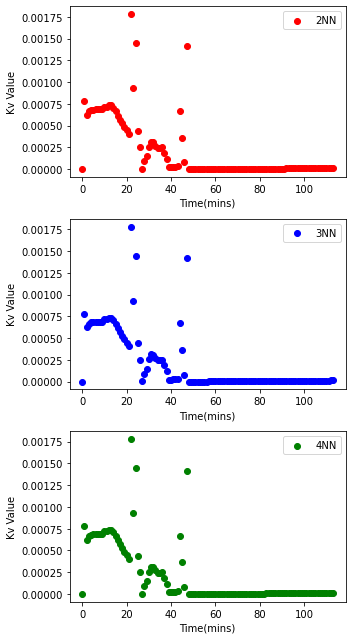

In [210]:
# Take Average Kv Values without outlier points and negative points
kv=np.array([kv_2,kv_3,kv_4])
avg=np.zeros(3)
x=["2NN","3NN","4NN"]
color=["red","blue","green"]

plt.figure(figsize=(5,9))
for i in range(3):
    # IQR
    kv
    Q1 = np.percentile(kv[i], 25,
                       interpolation = 'midpoint')
    Q3 = np.percentile(kv[i], 75,
                       interpolation = 'midpoint')
    IQR = Q3 - Q1

    # Above Upper bound
    upper = kv[i,:] >= (Q3+1.5*IQR)
    drop=(np.where(upper))[0]

    # Below Lower bound
    lower = kv[i,:] <= (Q1-1.5*IQR)
    drop=np.append(drop,np.where(lower)[0])
    print("Number of Outliers for",x[i],":",drop.shape[0])
    
    #Drop Outliers
    kv_out=np.delete(kv_2,drop)
    print(kv_out.shape)
    
    #Drop Negative Values
    ind=[]
    for j in range(len(kv_out)):
        if kv_out[j]<0:
            ind.append(j)
    print("Number of Negative Values for",x[i],":",len(ind))
    kv_out=np.delete(kv_out,ind)
    print(kv_out.shape)
    
    #Find Average and Store
    avg[i]=np.mean(kv_out*100)
    
    #Plot
    plt.subplot(3, 1, i+1)
    plt.scatter(np.arange(0,kv_out.shape[0],1),kv_out*100,color=color[i],label=x[i])
    plt.xlabel("Time(mins)")
    plt.ylabel("Kv Value")
    plt.legend()
    plt.tight_layout()
for i in range(3):
    print("Avg Kv for",x[i],":",avg[i])

Ask about the magnitude factor(100). When I used this value it fitted way better than the value from the hyperplane fitting.